In [1]:
# Binary Classifier implementation (model architecture, training, testing, etc.) derived from
#     https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89

In [2]:
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tree import Tree
import numpy as np
import pickle
import random
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from stanfordcorenlp import StanfordCoreNLP
import string
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [3]:
MAX_PHRASE_LEN = 6
VECTOR_SIZE = 200
WINDOW_SIZE = 5
NUM_LAYERS = 5

MIN_FREQUENCY = 5

SHOULD_EXTRACT_NOUN_PHRASES = False
SHOULD_GENERATE_UNDERSCORED_CORPUS = True
SHOULD_TRAIN_WORD2VEC_MODEL = True

EPOCHS = 200
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [4]:
with open('data/arxiv_abstracts_10000.txt', 'r') as f:
    arxiv_abstracts = f.read().split('\n')[:-1]
    arxiv_abstracts_raw = '\n'.join(arxiv_abstracts)
    f.close()
print(f'Loaded {len(arxiv_abstracts)} arxiv abstracts.')

Loaded 10000 arxiv abstracts.


In [5]:
negative_samples = pickle.load(open('data/negative_samples.pkl', 'rb'))
print(f'Loaded {len(negative_samples)} negative samples.')

Loaded 1900 negative samples.


In [6]:
positive_samples = pickle.load(open('data/positive_samples.pkl', 'rb'))
print(f'Loaded {len(positive_samples)} positive samples.')

Loaded 1900 positive samples.


In [7]:
def extract_phrase(tree_str, label):
    phrases = []
    trees = Tree.fromstring(tree_str)
    for tree in trees:
        for subtree in tree.subtrees():
            if subtree.label() == label:
                t = subtree
                t = ' '.join(t.leaves())
                phrases.append(t)
    return phrases

In [8]:
if SHOULD_EXTRACT_NOUN_PHRASES:
    nlp = StanfordCoreNLP('data/stanford-corenlp-4.1.0')
    noun_phrases = []
    for i, abstract in enumerate(arxiv_abstracts):
        if (i + 1) % 10 == 0:
            print(f'Extracting noun phrases from abstract {i + 1} of {len(arxiv_abstracts)}')
            pickle.dump(noun_phrases, open('data/noun_phrases.pkl', 'wb'))
        try:
            tree_str = nlp.parse(abstract)
            noun_phrases.extend(extract_phrase(tree_str, 'NP'))
        except Exception:
            pass
    noun_phrases = [np for np in list(set(noun_phrases)) if len(np.split()) <= MAX_PHRASE_LEN]
    pickle.dump(noun_phrases, open('data/noun_phrases.pkl', 'wb'))
noun_phrases = pickle.load(open('data/noun_phrases.pkl', 'rb'))
noun_phrases = [np for np in list(set(noun_phrases)) if len(np.split()) <= MAX_PHRASE_LEN]

In [9]:
def find_phrase_in_corpus(corpus, phrase):
    s_idx = corpus.find(phrase)
    e_idx = s_idx + len(phrase)
    if s_idx != -1 and \
       (s_idx == 0 or corpus[s_idx - 1] in (string.punctuation + ' ')) and \
       (e_idx == len(corpus) or corpus[e_idx] in (string.punctuation + ' ')):
        return (s_idx, e_idx)
    return (-1, -1)

In [10]:
if SHOULD_GENERATE_UNDERSCORED_CORPUS:
    corpus = arxiv_abstracts_raw[:]

In [11]:
if SHOULD_GENERATE_UNDERSCORED_CORPUS:
    for i, positive_sample in enumerate(positive_samples):
        if (i + 1) % 100 == 0:
            print(f'Replacing positive_sample {i + 1} of {len(positive_samples)}')
        found_indices = set()
        while find_phrase_in_corpus(corpus, positive_sample) != (-1, -1) and find_phrase_in_corpus(corpus, positive_sample)[0] not in found_indices:
            s_idx, e_idx = find_phrase_in_corpus(corpus, positive_sample)
            found_indices.add(s_idx)
            corpus = corpus[:s_idx] + positive_sample.replace(' ', '_') + corpus[e_idx:]

Replacing positive_sample 100 of 1900
Replacing positive_sample 200 of 1900
Replacing positive_sample 300 of 1900
Replacing positive_sample 400 of 1900
Replacing positive_sample 500 of 1900
Replacing positive_sample 600 of 1900
Replacing positive_sample 700 of 1900
Replacing positive_sample 800 of 1900
Replacing positive_sample 900 of 1900
Replacing positive_sample 1000 of 1900
Replacing positive_sample 1100 of 1900
Replacing positive_sample 1200 of 1900
Replacing positive_sample 1300 of 1900
Replacing positive_sample 1400 of 1900
Replacing positive_sample 1500 of 1900
Replacing positive_sample 1600 of 1900
Replacing positive_sample 1700 of 1900
Replacing positive_sample 1800 of 1900
Replacing positive_sample 1900 of 1900


In [12]:
if SHOULD_GENERATE_UNDERSCORED_CORPUS:
    for i, negative_sample in enumerate(negative_samples):
        if (i + 1) % 100 == 0:
            print(f'Replacing negative_sample {i + 1} of {len(negative_samples)}')
        found_indices = set()
        while find_phrase_in_corpus(corpus, negative_sample) != (-1, -1) and find_phrase_in_corpus(corpus, negative_sample)[0] not in found_indices:
            s_idx, e_idx = find_phrase_in_corpus(corpus, negative_sample)
            found_indices.add(s_idx)
            corpus = corpus[:s_idx] + negative_sample.replace(' ', '_') + corpus[e_idx:]

Replacing negative_sample 100 of 1900
Replacing negative_sample 200 of 1900
Replacing negative_sample 300 of 1900
Replacing negative_sample 400 of 1900
Replacing negative_sample 500 of 1900
Replacing negative_sample 600 of 1900
Replacing negative_sample 700 of 1900
Replacing negative_sample 800 of 1900
Replacing negative_sample 900 of 1900
Replacing negative_sample 1000 of 1900
Replacing negative_sample 1100 of 1900
Replacing negative_sample 1200 of 1900
Replacing negative_sample 1300 of 1900
Replacing negative_sample 1400 of 1900
Replacing negative_sample 1500 of 1900
Replacing negative_sample 1600 of 1900
Replacing negative_sample 1700 of 1900
Replacing negative_sample 1800 of 1900
Replacing negative_sample 1900 of 1900


In [13]:
if SHOULD_GENERATE_UNDERSCORED_CORPUS:
    for i, noun_phrase in enumerate(noun_phrases):
        if (i + 1) % 100 == 0:
            print(f'Replacing noun_phrase {i + 1} of {len(noun_phrases)}')
        found_indices = set()
        while find_phrase_in_corpus(corpus, noun_phrase) != (-1, -1) and find_phrase_in_corpus(corpus, noun_phrase)[0] not in found_indices:
            s_idx, e_idx = find_phrase_in_corpus(corpus, noun_phrase)
            found_indices.add(s_idx)
            corpus = corpus[:s_idx] + noun_phrase.replace(' ', '_') + corpus[e_idx:]

Replacing noun_phrase 100 of 38952
Replacing noun_phrase 200 of 38952
Replacing noun_phrase 300 of 38952
Replacing noun_phrase 400 of 38952
Replacing noun_phrase 500 of 38952
Replacing noun_phrase 600 of 38952
Replacing noun_phrase 700 of 38952
Replacing noun_phrase 800 of 38952
Replacing noun_phrase 900 of 38952
Replacing noun_phrase 1000 of 38952
Replacing noun_phrase 1100 of 38952
Replacing noun_phrase 1200 of 38952
Replacing noun_phrase 1300 of 38952
Replacing noun_phrase 1400 of 38952
Replacing noun_phrase 1500 of 38952
Replacing noun_phrase 1600 of 38952
Replacing noun_phrase 1700 of 38952
Replacing noun_phrase 1800 of 38952
Replacing noun_phrase 1900 of 38952
Replacing noun_phrase 2000 of 38952
Replacing noun_phrase 2100 of 38952
Replacing noun_phrase 2200 of 38952
Replacing noun_phrase 2300 of 38952
Replacing noun_phrase 2400 of 38952
Replacing noun_phrase 2500 of 38952
Replacing noun_phrase 2600 of 38952
Replacing noun_phrase 2700 of 38952
Replacing noun_phrase 2800 of 38952
R

In [14]:
if SHOULD_GENERATE_UNDERSCORED_CORPUS:
    pickle.dump(corpus, open('data/underscored_corpus.pkl', 'wb'))

In [15]:
underscored_corpus = pickle.load(open('data/underscored_corpus.pkl', 'rb'))

In [16]:
if SHOULD_TRAIN_WORD2VEC_MODEL:
    underscored_corpus_data = []
    for i in sent_tokenize(underscored_corpus):
        temp = []
        for j in word_tokenize(i):
            temp.append(j.lower())
        underscored_corpus_data.append(temp)

In [17]:
if SHOULD_TRAIN_WORD2VEC_MODEL:
    word2vec_model = Word2Vec(underscored_corpus_data, min_count=1, window=WINDOW_SIZE, size=VECTOR_SIZE)
    word2vec_model.save(f'data/word2vec_model_vs_{VECTOR_SIZE}_ws_{WINDOW_SIZE}')

In [18]:
word2vec_model = Word2Vec.load(f'data/word2vec_model_vs_{VECTOR_SIZE}_ws_{WINDOW_SIZE}')

In [19]:
tokens = [token for token in list(word2vec_model.wv.vocab.keys())]
embeddings = {token: word2vec_model.wv[token] for token in tokens}

In [20]:
positive_samples = [ps for ps in positive_samples if ps.replace(' ', '_') in embeddings and word2vec_model.wv.vocab[ps.replace(' ', '_')].count >= MIN_FREQUENCY]
negative_samples = [ns for ns in negative_samples if ns.replace(' ', '_') in embeddings and word2vec_model.wv.vocab[ns.replace(' ', '_')].count >= MIN_FREQUENCY]

positive_samples = positive_samples[:min(len(positive_samples), len(negative_samples))]
negative_samples = negative_samples[:min(len(positive_samples), len(negative_samples))]

ps_set = set(positive_samples)
ns_set = set(negative_samples)

noun_phrases = [np for np in noun_phrases if np not in ps_set and np not in ns_set and np.replace(' ', '_') in embeddings and word2vec_model.wv.vocab[np.replace(' ', '_')].count >= MIN_FREQUENCY]

In [21]:
X = []
y = []
for phrase in positive_samples:
    X.append(embeddings[phrase.replace(' ', '_')])
    y.append(1)
for phrase in negative_samples:
    X.append(embeddings[phrase.replace(' ', '_')])
    y.append(0)

In [22]:
c = list(zip(X, y))
random.shuffle(c)
X, y = zip(*c)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [24]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()

        self.layer_1 = nn.Linear(VECTOR_SIZE, 128)
        
        self.layers = []
        for _ in range(NUM_LAYERS - 1):
            self.layers.append(nn.Linear(128, 128))
        
        self.layer_out = nn.Linear(128, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        
        for layer in self.layers:
            x = self.relu(layer(x))

        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BinaryClassifier()
model.to(device)

BinaryClassifier(
  (layer_1): Linear(in_features=200, out_features=128, bias=True)
  (layer_out): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [26]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [27]:
class TrainDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

train_data = TrainDataset(torch.FloatTensor(np.array(X_train, dtype=np.float64)), 
                          torch.FloatTensor(y_train))

In [28]:
class TestDataset(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestDataset(torch.FloatTensor(np.array(X_test, dtype=np.float64)))

In [29]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [30]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [31]:
epoch_losses = []
for e in range(1, EPOCHS + 1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)

        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    epoch_losses.append(epoch_loss / len(train_loader)) 

    if e % 10 == 0:
        print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 010: | Loss: 0.61554 | Acc: 68.560
Epoch 020: | Loss: 0.56229 | Acc: 70.800
Epoch 030: | Loss: 0.53755 | Acc: 72.200
Epoch 040: | Loss: 0.51566 | Acc: 73.760
Epoch 050: | Loss: 0.50253 | Acc: 75.080
Epoch 060: | Loss: 0.48779 | Acc: 75.920
Epoch 070: | Loss: 0.47238 | Acc: 76.800
Epoch 080: | Loss: 0.46857 | Acc: 77.160
Epoch 090: | Loss: 0.45862 | Acc: 77.280
Epoch 100: | Loss: 0.44780 | Acc: 77.360
Epoch 110: | Loss: 0.43806 | Acc: 78.280
Epoch 120: | Loss: 0.42915 | Acc: 78.120
Epoch 130: | Loss: 0.42767 | Acc: 78.880
Epoch 140: | Loss: 0.42287 | Acc: 77.920
Epoch 150: | Loss: 0.41563 | Acc: 78.600
Epoch 160: | Loss: 0.41494 | Acc: 78.440
Epoch 170: | Loss: 0.41445 | Acc: 78.760
Epoch 180: | Loss: 0.40144 | Acc: 80.360
Epoch 190: | Loss: 0.39415 | Acc: 79.880
Epoch 200: | Loss: 0.38854 | Acc: 81.080


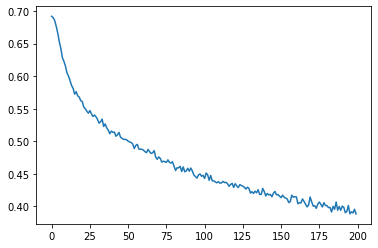

In [32]:
plt.plot(epoch_losses)

In [33]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [34]:
print(confusion_matrix(y_test, y_pred_list))
print(classification_report(y_test, y_pred_list))

[[121  57]
 [ 58 153]]
              precision    recall  f1-score   support

           0       0.68      0.68      0.68       178
           1       0.73      0.73      0.73       211

    accuracy                           0.70       389
   macro avg       0.70      0.70      0.70       389
weighted avg       0.70      0.70      0.70       389



In [35]:
test_samples = random.sample(noun_phrases, 1000)
X_samples = []
for sample in test_samples:
    X_samples.append(embeddings[sample.replace(' ', '_')])
sample_data = TestDataset(torch.FloatTensor(np.array(X_samples, dtype=np.float64)))
sample_loader = DataLoader(dataset=sample_data, batch_size=1)

extracted = {}
not_extracted = {}
model.eval()
with torch.no_grad():
    for i, X_batch in enumerate(sample_loader):
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        if y_pred_tag.cpu().numpy()[0][0] == 1:
            extracted[test_samples[i]] = y_test_pred.item()
        else:
            not_extracted[test_samples[i]] = y_test_pred.item()

In [36]:
articles = set(['a', 'the', 'an'])
extracted = {k: v for k, v in sorted(extracted.items(), key=lambda x: x[1], reverse=True) if k.split()[0] not in articles}

In [37]:
extracted

{'dataset': 0.9999998807907104,
 'method': 0.9999995231628418,
 'patient': 0.9994611144065857,
 'short term memory': 0.9993560910224915,
 'part': 0.9979509711265564,
 'focus': 0.997767448425293,
 'random field': 0.9943311214447021,
 'area': 0.9942725896835327,
 'limits': 0.9936187267303467,
 'general': 0.991628885269165,
 'de': 0.9913837909698486,
 'us': 0.9913699626922607,
 'fisher': 0.9892249703407288,
 'mobile': 0.9887565970420837,
 'basis': 0.9868499040603638,
 'scale': 0.9850148558616638,
 'nonlinear': 0.9844915270805359,
 'emotion': 0.9839656352996826,
 'integer': 0.9772638082504272,
 'mri': 0.9770360589027405,
 'mixture': 0.9743661880493164,
 'decision': 0.9731950163841248,
 'w': 0.9696369767189026,
 'maximum': 0.9694655537605286,
 'extracts': 0.9650328755378723,
 '2013': 0.9628392457962036,
 'unsupervised': 0.9626750349998474,
 'fmri': 0.9589870572090149,
 'item': 0.9582691788673401,
 'method which': 0.9574536085128784,
 'news': 0.9567950963973999,
 '2012': 0.9540184736251831,


In [38]:
not_extracted = {k: v for k, v in sorted(not_extracted.items(), key=lambda x: x[1], reverse=False)}

In [39]:
not_extracted

{'the effectiveness': 5.73126953895553e-07,
 'samples': 5.327800863597076e-06,
 'works': 8.802426236798055e-06,
 'instances': 3.7580819480353966e-05,
 'size': 8.721094491193071e-05,
 'values': 0.00010886265226872638,
 'distributions': 0.00012562084884848446,
 'less': 0.00013326818589121103,
 'results': 0.00014533418288920075,
 'networks': 0.0001558802032377571,
 'words': 0.00021382964041549712,
 'the current state': 0.0005454190541058779,
 'cases': 0.0006047742208465934,
 'improvements': 0.0006287351716309786,
 'neural networks cnns': 0.0006426469190046191,
 'elements': 0.0009186253882944584,
 'the features': 0.0010169079760089517,
 'advances': 0.0016336722765117884,
 'paths': 0.0019249666947871447,
 's': 0.002392793772742152,
 'features': 0.003200931241735816,
 'orders': 0.003708937205374241,
 'the number': 0.004026979673653841,
 'concepts': 0.004267136100679636,
 'skills': 0.00452770758420229,
 'a mixture': 0.004674387164413929,
 'the classes': 0.005775765050202608,
 'the efficiency'

In [40]:
pickle.dump(extracted, open(f'data/pem_extracted_vs_{VECTOR_SIZE}_ws_{WINDOW_SIZE}_nl_{NUM_LAYERS}_mf_{MIN_FREQUENCY}_e_{EPOCHS}.pkl', 'wb'))